In [1]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pymaster as nmt

In [2]:
nsim = 10
nside = 128
angfrac = 25
lmax = 3*nside-1

In [3]:
def get_mask_yuyang():
    th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    ph[np.where(ph > np.pi)[0]] -= 2 * np.pi
    mask = np.zeros(hp.nside2npix(nside))
    mask[np.where(np.sqrt(ph**2+((th-np.pi/2)/1)**2)<np.pi/angfrac)[0]] = 1.
    msk_apo = nmt.mask_apodization(mask, 5, apotype='C1')
    return msk_apo


def get_mask_analytic(ns, aps, fsk=0.0945, dec0=0., ra0=0.) :
    #This generates a correctly-apodized mask
    DTOR = np.pi/180
    v0=np.array([np.sin(DTOR*(90-dec0))*np.cos(DTOR*ra0),
                 np.sin(DTOR*(90-dec0))*np.sin(DTOR*ra0),
                 np.cos(DTOR*(90-dec0))])
    vv=np.array(hp.pix2vec(ns,np.arange(hp.nside2npix(ns))))
    cth=np.sum(v0[:,None]*vv,axis=0); th=np.arccos(cth); th0=np.arccos(1-2*fsk); th_apo=aps*DTOR
    id0=np.where(th>=th0)[0]
    id1=np.where(th<=th0-th_apo)[0]
    idb=np.where((th>th0-th_apo) & (th<th0))[0]
    x=np.sqrt((1-np.cos(th[idb]-th0))/(1-np.cos(th_apo)))
    mask_apo=np.zeros(hp.nside2npix(ns))
    mask_apo[id0]=0.
    mask_apo[id1]=1.
    mask_apo[idb]=x-np.sin(2*np.pi*x)/(2*np.pi)
    return mask_apo

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

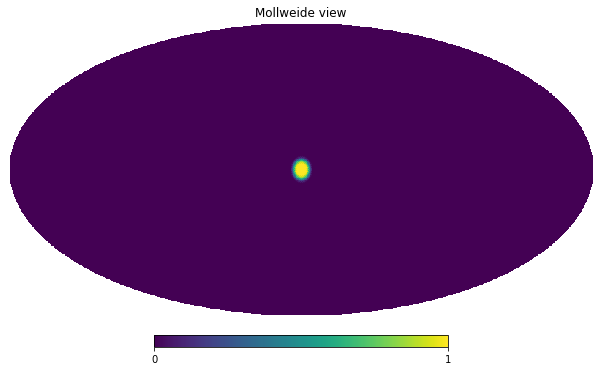

In [4]:
msk_apo = get_mask_analytic(nside, 5., fsk=0.0945/22.7)
# Binary mask
msk_bin = np.ones_like(msk_apo)
msk_bin[msk_apo <= 0] = 0
hp.mollview(msk_apo)

In [5]:
b = nmt.NmtBin.from_nside_linear(nside, 32)
leff = b.get_effective_ells()
l, cltt, clee, clbb, clte = np.loadtxt('totcls_r0.txt', unpack=True)
prefactor = 2*np.pi/(l*(l+1))
prefactor[0] = 0.
cltt *= prefactor
clee *= prefactor
clbb *= prefactor
clte *= prefactor
cltt = cltt[:3*nside]
clee = clee[:3*nside]
clbb = clbb[:3*nside]
clte = clte[:3*nside]
cl_th = np.array([clee, np.zeros_like(clee), np.zeros_like(clee), clbb])

<ipython-input-5-63ba3d68b498>:4: RuntimeWarning: divide by zero encountered in true_divide
  prefactor = 2*np.pi/(l*(l+1))


In [6]:
def get_fields():
    mp_t, mp_q, mp_u = hp.synfast([cltt, clee, clbb, clte], nside=nside,
                                  lmax=lmax, new=True, verbose=False)
    # This creates a spin-2 field without purifying either E or B
    f2_np = nmt.NmtField(msk_apo, [mp_q*msk_bin, mp_u*msk_bin])
    # This creates a spin-2 field with both pure E and B.
    f2_yp = nmt.NmtField(msk_apo, [mp_q*msk_bin, mp_u*msk_bin],
                         purify_b=True, n_iter_mask_purify=10)
    # Note that generally it's not a good idea to purify both,
    # since you'll lose sensitivity on E
    return f2_np, f2_yp

In [7]:
# Get workspaces
f2np0, f2yp0 = get_fields()
w_np = nmt.NmtWorkspace()
w_np.compute_coupling_matrix(f2np0, f2np0, b)
w_yp = nmt.NmtWorkspace()
w_yp.compute_coupling_matrix(f2yp0, f2yp0, b)

# Theory C_ells
cl_th_np = w_np.decouple_cell(w_np.couple_cell(cl_th))
cl_th_yp = w_yp.decouple_cell(w_yp.couple_cell(cl_th))

In [8]:
# Loop over simulations
cls_np = []
cls_yp = []
for i in range(nsim):
    print(i)
    fn, fy = get_fields()
    cls_np.append(w_np.decouple_cell(nmt.compute_coupled_cell(fn, fn)))
    cls_yp.append(w_yp.decouple_cell(nmt.compute_coupled_cell(fy, fy)))
cls_np = np.array(cls_np)
cls_yp = np.array(cls_yp)
cl_np = np.mean(cls_np, axis=0)
el_np = np.std(cls_np, axis=0)
cl_yp = np.mean(cls_yp, axis=0)
el_yp = np.std(cls_yp, axis=0)

0
1
2
3
4
5
6
7
8
9


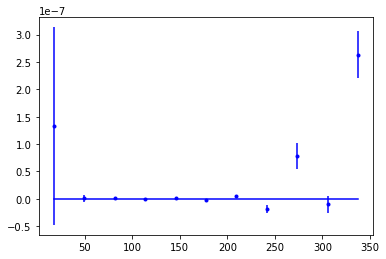

In [10]:
# Plot results
plt.figure()
plt.errorbar(leff, cl_yp[3], yerr=el_yp[3], fmt='b.')
#plt.errorbar(leff, cl_np[3], yerr=el_np[3], fmt='r.')

plt.plot(leff, cl_th_yp[3], 'b-')
#plt.plot(leff, cl_th_np[3], 'r-')


#plt.yscale('log')
#plt.xscale('log')

plt.show()